# **Fixed Income and Derivatives II - Coursework**
## **Credit Default Swap (CDS) Pricing and Sensitivities Analysis**

### **Introduction**
This notebook presents the implementation of Credit Default Swap (CDS) pricing using a Monte Carlo framework. The goal of this coursework is to compute the present value of a CDS contract while incorporating various sensitivity analyses. The CDS valuation consists of premium leg and default leg calculations, allowing us to assess risk and pricing dynamics under different market conditions.

### **Objectives**
The key objectives of this analysis are:
- To implement a function that calculates the price of a Credit Default Swap (CDS).
- To analyze the impact of key parameters on the CDS pricing.
- To evaluate sensitivities with respect to:
  - Interest rate (risk-free rate)
  - Par CDS spread
  - Recovery rate

### **Methodology**
1. **CDS Pricing Function:**
   - The function computes the CDS value by summing the present value of premium leg payments and default leg payments.
   - The valuation accounts for the survival probabilities of the reference entity.
   - The pricing differs depending on whether the counterparty is a **buyer** or **seller** of protection.

2. **Par CDS Spread Sensitivity:**
   - The effect of changes in the CDS spread is analyzed.
   - The sensitivity is computed by **bumping** the CDS spread by 1 basis point (bp) and observing the impact on CDS value.

3. **Interest Rate Sensitivity:**
   - The valuation is tested against changes in the risk-free rate.
   - The effect of a **1bp change** in interest rates on CDS pricing is visualized.

4. **Recovery Rate Sensitivity:**
   - The impact of varying the recovery rate of the underlying entity on the CDS price.
   - A small increase in the recovery rate is tested to compute the price change.

5. **Par CDS Spread Sensitivity to Recovery Rate Changes:**
   - The combined effect of changing recovery rates and CDS spreads on pricing.
   - This helps assess how changes in credit risk influence protection payments.

### **Structure of the Notebook**
The notebook is structured as follows:
1. **Implementation of the CDS Pricing Function**
2. **Interest Rate Sensitivity Analysis**
3. **Par CDS Spread Sensitivity**
4. **Recovery Rate Sensitivity**
5. **Impact of Recovery Rate on CDS Spread Sensitivity**

Each section includes:
- A well-commented Python function to perform calculations.
- Professional and clear **plots** to visualize the results.
- A logical explanation of the results obtained.

### **Expected Results**
- The sensitivity graphs should show how small changes in spreads, interest rates, or recovery rates affect the CDS price.
- The findings should provide insights into the risk exposure of CDS contracts in different market conditions.

### **Key Assumptions**
- The risk-free rate is assumed constant over the life of the CDS.
- Survival probabilities follow an **exponential hazard rate model**.
- The discounting follows a standard **continuous compounding** approach.
- The analysis is conducted for a **payer CDS position** (buyer of protection).

---

This notebook aims to provide a structured, well-documented, and insightful approach to **CDS valuation and risk analysis**. Let's begin the implementation.


# 1. Different Random Process

## a) Gaussian Random Number Generation

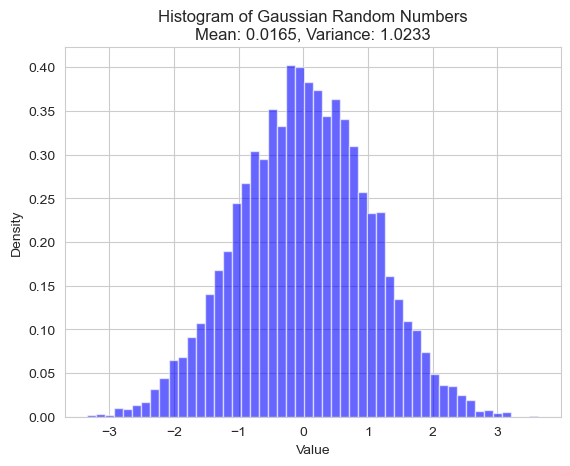

Mean: 0.0165
Variance: 1.0233


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate 10,000 Gaussian random numbers (mean=0, std=1)
data = np.random.randn(10000)

# Compute mean and variance
mean_value = np.mean(data)
variance_value = np.var(data)

# Plot histogram
plt.hist(data, bins=50, density=True, alpha=0.6, color='b')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'Histogram of Gaussian Random Numbers\nMean: {mean_value:.4f}, Variance: {variance_value:.4f}')
plt.grid(True)
plt.show()

# Print mean and variance
print(f"Mean: {mean_value:.4f}")
print(f"Variance: {variance_value:.4f}")

## b) Wiener Process Simulation

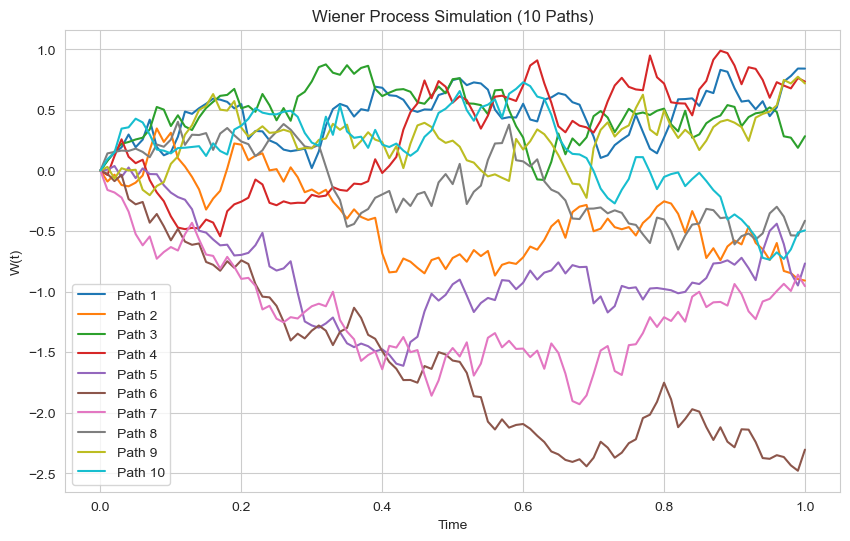

In [49]:
def wiener_process(N=100, T=1, paths=10):
    dt = T / N  # Time step
    t = np.linspace(0, T, N+1)  # Time vector
    dW = np.sqrt(dt) * np.random.randn(paths, N)  # Brownian increments
    W = np.cumsum(dW, axis=1)  # Cumulative sum to create paths
    W = np.hstack((np.zeros((paths, 1)), W))  # Add initial zero
    
    # Plot paths
    plt.figure(figsize=(10, 6))
    for i in range(paths):
        plt.plot(t, W[i, :], label=f'Path {i+1}')
    
    plt.xlabel('Time')
    plt.ylabel('W(t)')
    plt.title('Wiener Process Simulation (10 Paths)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Run the Wiener process simulation
wiener_process()

## c) Wiener Process Times Series Analysis

In [52]:
def wiener_process_simulation(N=100, T=3, simulations=10000):
    dt = T / N  # Time step
    t = np.linspace(0, T, N+1)  # Time vector
    dW = np.sqrt(dt) * np.random.randn(simulations, N)  # Brownian increments
    W = np.cumsum(dW, axis=1)  # Cumulative sum to create paths
    W = np.hstack((np.zeros((simulations, 1)), W))  # Add initial zero
    
    # Extract values at T = 1, 2, 3 years
    indices = [int(N * (i/T)) for i in range(1, T+1)]
    W_T_values = W[:, indices]
    
    # Compute mean and variance
    means = np.mean(W_T_values, axis=0)
    variances = np.var(W_T_values, axis=0)
    
    # Display results
    for i, year in enumerate(range(1, T+1)):
        print(f"Year {year}: Mean = {means[i]:.4f}, Variance = {variances[i]:.4f}")
    
# Run the simulation
wiener_process_simulation()

Year 1: Mean = 0.0086, Variance = 0.9908
Year 2: Mean = 0.0002, Variance = 1.9936
Year 3: Mean = 0.0118, Variance = 3.0034


## d) Geometric Brownian Motion (GBM) Simulation

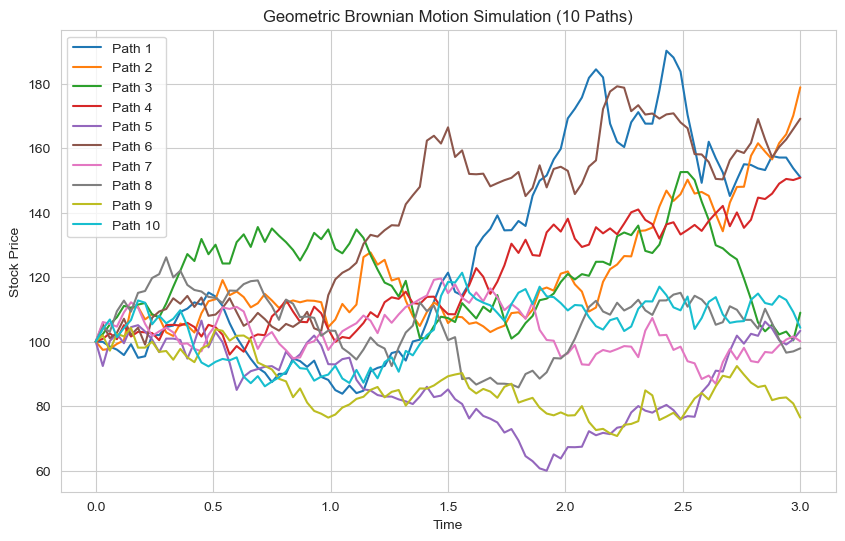

In [53]:
def geometric_brownian_motion(S0=100, mu=0.05, sigma=0.2, T=3, N=100, paths=10):
    dt = T / N  # Time step
    t = np.linspace(0, T, N+1)  # Time vector
    dW = np.sqrt(dt) * np.random.randn(paths, N)  # Brownian increments
    W = np.cumsum(dW, axis=1)  # Wiener process
    W = np.hstack((np.zeros((paths, 1)), W))  # Add initial zero
    
    # Compute GBM paths
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    
    # Plot paths
    plt.figure(figsize=(10, 6))
    for i in range(paths):
        plt.plot(t, S[i, :], label=f'Path {i+1}')
    
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Geometric Brownian Motion Simulation (10 Paths)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Run the GBM simulation
geometric_brownian_motion()

## e) Lognormal Process Simulation (One Giant Step)

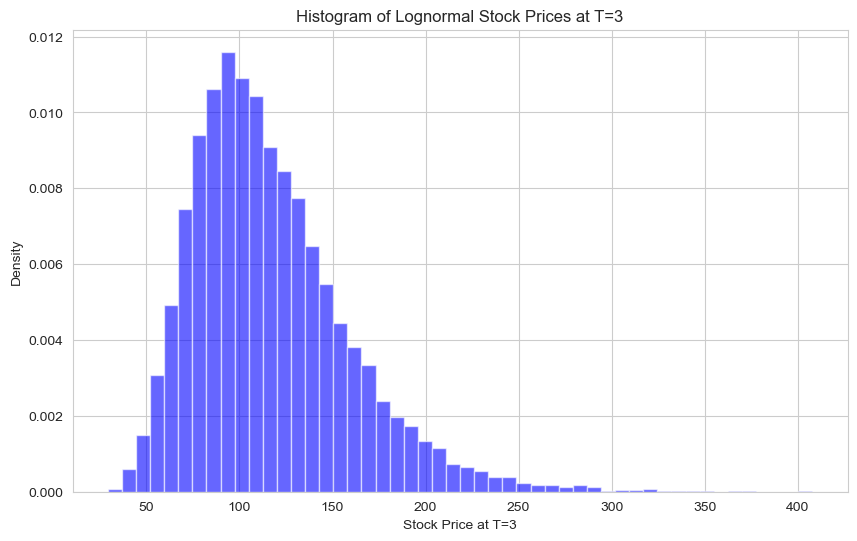

In [54]:
def lognormal_process(S0=100, mu=0.05, sigma=0.2, T=3, P=10000):
    Z = np.random.randn(P)  # Standard normal random variables
    S_T = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)  # One giant step formula
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(S_T, bins=50, density=True, alpha=0.6, color='b')
    plt.xlabel('Stock Price at T=3')
    plt.ylabel('Density')
    plt.title('Histogram of Lognormal Stock Prices at T=3')
    plt.grid(True)
    plt.show()

# Run the lognormal process simulation
lognormal_process()

# 2. Black-Scholes-Merton Hedging

## a) Black-Scholes Call Option Pricing and Delta Calculation

In [55]:
def black_scholes_call_price(S, K, T, r, sigma):
    """
    Compute the Black-Scholes price of a European call option.
    
    Parameters:
    S : float  - Current stock price
    K : float  - Strike price
    T : float  - Time to maturity (in years)
    r : float  - Risk-free interest rate (annualized)
    sigma : float  - Volatility of the stock (annualized)
    
    Returns:
    float - Call option price
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_call_delta(S, K, T, r, sigma):
    """
    Compute the Black-Scholes delta of a European call option.
    
    Parameters:
    S : float  - Current stock price
    K : float  - Strike price
    T : float  - Time to maturity (in years)
    r : float  - Risk-free interest rate (annualized)
    sigma : float  - Volatility of the stock (annualized)
    
    Returns:
    float - Call option delta
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

# Example usage
S = 100  # Stock price
K = 100  # Strike price
T = 1    # Time to maturity (1 year)
r = 0.05  # Risk-free rate (5%)
sigma = 0.2  # Volatility (20%)

call_price = black_scholes_call_price(S, K, T, r, sigma)
delta = black_scholes_call_delta(S, K, T, r, sigma)

print(f"Black-Scholes Call Price: {call_price:.4f}")
print(f"Call Option Delta: {delta:.4f}")


Black-Scholes Call Price: 10.4506
Call Option Delta: 0.6368


## b) Option Path Simulation for Delta Hedging

In [56]:
def option_path_sim(K, S0, r, sigma, T, N):
    """
    Simulates delta hedging for a European call option using the Black-Scholes formula.
    
    Parameters:
    K : float  - Strike price
    S0 : float  - Initial stock price
    r : float  - Risk-free interest rate
    sigma : float  - Volatility
    T : float  - Time to expiry
    N : int  - Number of hedging steps per year
    
    Returns:
    tuple - (Terminal stock price, Call option payoff, Shares held, Cash balance, Portfolio value, Replicating error)
    """
    dt = T / N  # Time step
    t = np.linspace(0, T, N+1)  # Time grid
    
    # Simulating stock price path using geometric Brownian motion
    dW = np.random.randn(N) * np.sqrt(dt)
    W = np.cumsum(dW)
    W = np.insert(W, 0, 0)  # Insert W(0) = 0
    S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)
    
    # Initialize hedging portfolio
    cash = 0
    shares_held = np.zeros(N+1)
    portfolio_value = np.zeros(N+1)
    
    for i in range(N+1):
        delta = norm.cdf((np.log(S[i] / K) + (r + 0.5 * sigma**2) * (T - t[i])) / (sigma * np.sqrt(T - t[i] + 1e-8)))
        if i == 0:
            shares_held[i] = delta
            cash -= delta * S[i]
        else:
            shares_held[i] = delta
            cash = cash * np.exp(r * dt) - (shares_held[i] - shares_held[i-1]) * S[i]
        portfolio_value[i] = shares_held[i] * S[i] + cash
    
    call_payoff = max(S[-1] - K, 0)
    replicating_error = portfolio_value[-1] - call_payoff
    
    return S[-1], call_payoff, shares_held[-1], cash, portfolio_value[-1], replicating_error

# Example usage
S_T, payoff, shares, cash, portfolio_value, error = option_path_sim(K=100, S0=100, r=0.05, sigma=0.2, T=1, N=252)
print(f"Terminal Stock Price: {S_T:.4f}")
print(f"Call Option Payoff: {payoff:.4f}")
print(f"Shares Held: {shares:.4f}")
print(f"Cash Balance: {cash:.4f}")
print(f"Portfolio Value: {portfolio_value:.4f}")
print(f"Replicating Error: {error:.4f}")

Terminal Stock Price: 121.0329
Call Option Payoff: 21.0329
Shares Held: 1.0000
Cash Balance: -111.4007
Portfolio Value: 9.6322
Replicating Error: -11.4007


## c) Option Simulation for Multiple Paths

In [29]:
def option_sim(K, S0, r, sigma, T, N, P):
    """
    Runs multiple simulations of option_path_sim to analyze hedging results.
    """
    results = [option_path_sim(K, S0, r, sigma, T, N) for _ in range(P)]
    return np.array(results)

# Example usage
P = 1000
sim_results = option_sim(K=100, S0=100, r=0.05, sigma=0.2, T=1, N=252, P=P)
mean_error = np.mean(sim_results[:, -1])
print(f"Mean Replicating Error over {P} paths: {mean_error:.4f}")

Mean Replicating Error over 1000 paths: -11.0054


## d) Scatterplot of Hedging Errors

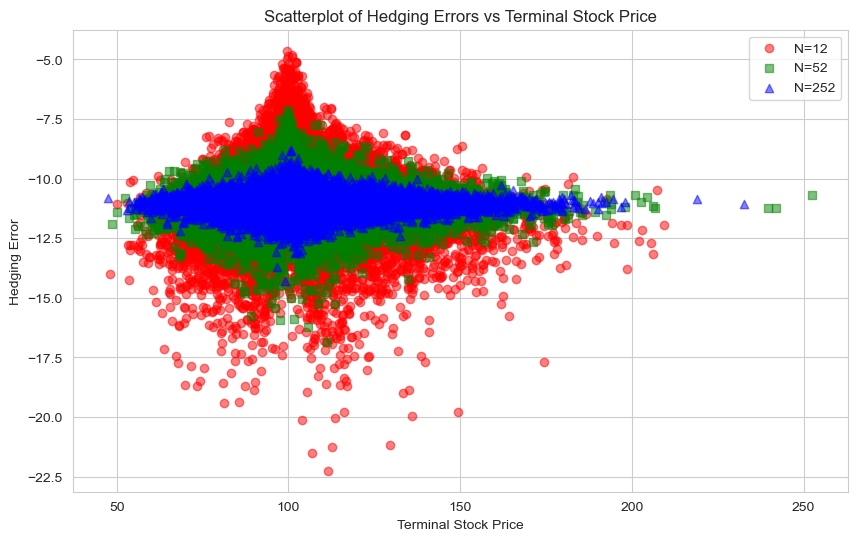

In [30]:
def plot_hedging_error_scatter(K, S0, r, sigma, T, P):
    """
    Generates scatterplots of hedging errors versus terminal stock prices for different hedging frequencies.
    """
    N_values = [12, 52, 252]
    markers = ['o', 's', '^']
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(10, 6))
    
    for N, marker, color in zip(N_values, markers, colors):
        sim_results = option_sim(K, S0, r, sigma, T, N, P)
        plt.scatter(sim_results[:, 0], sim_results[:, -1], label=f'N={N}', alpha=0.5, marker=marker, color=color)
    
    plt.xlabel("Terminal Stock Price")
    plt.ylabel("Hedging Error")
    plt.title("Scatterplot of Hedging Errors vs Terminal Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
P = 10000
plot_hedging_error_scatter(K=100, S0=100, r=0.05, sigma=0.2, T=1, P=P)

# 3. Digital Equity Options using Monte Carlo

## a) Digital Call Option Pricing using Monte Carlo

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def digital(S0, K, T0, T, r, sigma, simulations=10000):
    """
    Prices a digital call option using Monte Carlo simulation.
    """
    dt = T - T0
    Z = np.random.randn(simulations)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    payoff = np.exp(-r * dt) * (ST > K)
    return np.mean(payoff)


## b) Digital Call Option Pricing using Monte Carlo with Antithetics

In [32]:
def digital_mc(S0, K, T0, T, r, sigma, P):
    """
    Prices a digital call option using Monte Carlo with Antithetic Variates.
    """
    dt = T - T0
    Z = np.random.randn(P // 2)
    ST1 = S0 * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    ST2 = S0 * np.exp((r - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt) * Z)
    
    payoff1 = np.exp(-r * dt) * (ST1 > K)
    payoff2 = np.exp(-r * dt) * (ST2 > K)
    
    return np.mean(np.concatenate((payoff1, payoff2)))


## c) One-Touch Digital Call Option Pricing using Monte Carlo with Antithetics

In [33]:
def one_touch(S0, K, T0, T, r, sigma, P):
    """
    Prices a one-touch digital call option using Monte Carlo with Antithetic Variates.
    """
    dt = T - T0
    Z = np.random.randn(P // 2, 1)  # Generate P/2 standard normal samples
    ST1 = S0 * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    ST2 = S0 * np.exp((r - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt) * Z)
    
    payoff1 = np.exp(-r * dt) * (np.any(ST1 > K, axis=1))
    payoff2 = np.exp(-r * dt) * (np.any(ST2 > K, axis=1))
    
    return np.mean(np.concatenate((payoff1, payoff2)))

## d) Plot Digital Option Prices as a Function of S0

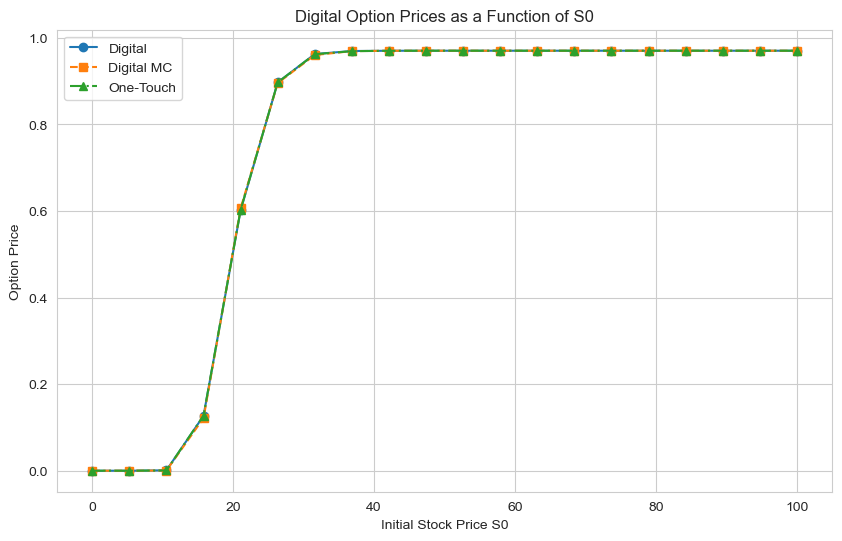

In [34]:
def plot_digital_prices(T, K, r, sigma, S0_range, steps, P):
    """
    Plots the values of digital, digital_mc, and one_touch as a function of S0.
    """
    S0_values = np.linspace(S0_range[0], S0_range[1], steps)
    prices_digital = [digital(S0, K, 0, T, r, sigma) for S0 in S0_values]
    prices_digital_mc = [digital_mc(S0, K, 0, T, r, sigma, P) for S0 in S0_values]
    prices_one_touch = [one_touch(S0, K, 0, T, r, sigma, P) for S0 in S0_values]
    
    plt.figure(figsize=(10, 6))
    plt.plot(S0_values, prices_digital, label='Digital', linestyle='-', marker='o')
    plt.plot(S0_values, prices_digital_mc, label='Digital MC', linestyle='--', marker='s')
    plt.plot(S0_values, prices_one_touch, label='One-Touch', linestyle='-.', marker='^')
    
    plt.xlabel("Initial Stock Price S0")
    plt.ylabel("Option Price")
    plt.title("Digital Option Prices as a Function of S0")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_digital_prices(T=1.0, K=20, r=0.03, sigma=0.20, S0_range=(0, 100), steps=20, P=10000)

# 4. Lookback Equity Option Pricing using Monte Carlo

## a) Lookback Floating Strike Call Option Pricing using Monte Carlo


In [ ]:
def float_strike(S0, T0, T, r, sigma, P, N=252):
    """
    Prices a lookback floating strike call option using Monte Carlo with Antithetic Variates.
    """
    dt = (T - T0) / N
    Z = np.random.randn(P // 2, N)  # Generate antithetic variates
    
    # Simulate stock price paths
    ST1 = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z, axis=1))
    ST2 = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt) * Z, axis=1))
    
    # Calculate the floating strike price (minimum stock price in each path)
    min_ST1 = np.min(ST1, axis=1)
    min_ST2 = np.min(ST2, axis=1)
    
    # Calculate the payoff for the lookback call option
    payoff1 = np.exp(-r * (T - T0)) * np.maximum(ST1[:, -1] - min_ST1, 0)
    payoff2 = np.exp(-r * (T - T0)) * np.maximum(ST2[:, -1] - min_ST2, 0)
    
    return np.mean(np.concatenate((payoff1, payoff2)))

## 5. Lookback Option Pricing using Monte Carlo

## b) Lookback Fixed Strike Call Option Pricing using Monte Carlo

In [36]:
def fixed_strike(S0, K, T0, T, r, sigma, P, N=252):
    """
    Prices a lookback fixed strike call option using Monte Carlo with Antithetic Variates.
    """
    dt = (T - T0) / N
    Z = np.random.randn(P // 2, N)  # Generate antithetic variates
    
    # Simulate stock price paths
    ST1 = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z, axis=1))
    ST2 = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt) * Z, axis=1))
    
    # Calculate the maximum stock price in each path
    max_ST1 = np.max(ST1, axis=1)
    max_ST2 = np.max(ST2, axis=1)
    
    # Calculate the payoff for the lookback call option
    payoff1 = np.exp(-r * (T - T0)) * np.maximum(max_ST1 - K, 0)
    payoff2 = np.exp(-r * (T - T0)) * np.maximum(max_ST2 - K, 0)
    
    return np.mean(np.concatenate((payoff1, payoff2)))

# Example usage
S0 = 100  # Initial stock price
K = 100   # Strike price
T0 = 0    # Current time
T = 1     # Time to maturity (1 year)
r = 0.05  # Risk-free rate (5%)
sigma = 0.2  # Volatility (20%)
P = 10000  # Number of Monte Carlo paths

price_fixed_strike = fixed_strike(S0, K, T0, T, r, sigma, P)
print(f"Estimated Lookback Fixed Strike Call Option Price: {price_fixed_strike:.4f}")


Estimated Lookback Fixed Strike Call Option Price: 18.2889


## c) Lookback Option Price Plot

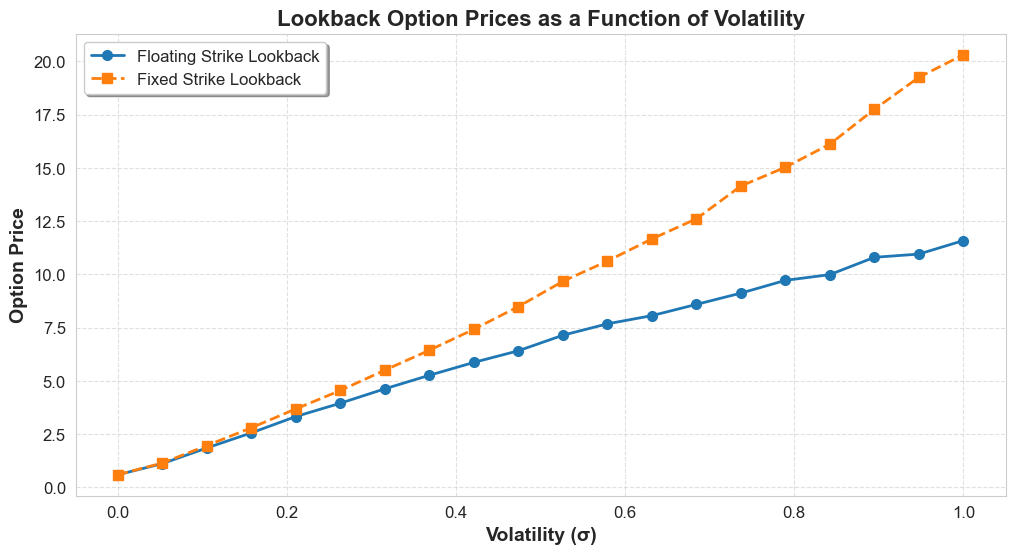

In [37]:
def plot_lookback_prices(T, S0, K, r, sigma_range, steps, P):
    """
    Plots the values of floating and fixed strike lookback call options as a function of volatility.
    """
    sigma_values = np.linspace(sigma_range[0], sigma_range[1], steps)
    prices_floating = [float_strike(S0, 0, T, r, sigma, P) for sigma in sigma_values]
    prices_fixed = [fixed_strike(S0, K, 0, T, r, sigma, P) for sigma in sigma_values]
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    plt.plot(sigma_values, prices_floating, label='Floating Strike Lookback', linestyle='-', marker='o', markersize=7, linewidth=2)
    plt.plot(sigma_values, prices_fixed, label='Fixed Strike Lookback', linestyle='--', marker='s', markersize=7, linewidth=2)
    
    plt.xlabel("Volatility (σ)", fontsize=14, fontweight='bold')
    plt.ylabel("Option Price", fontsize=14, fontweight='bold')
    plt.title("Lookback Option Prices as a Function of Volatility", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.show()

# Example usage
plot_lookback_prices(T=1.0, S0=20, K=20, r=0.03, sigma_range=(0, 1.0), steps=20, P=10000)


# 5. Valuation of Basket Options

# a) Basket Options Pricing using Monte Carlo

In [38]:
def basket_best(S0, T, r, sigma, beta, N, P):
    """
    Prices a best-of basket option using Monte Carlo with Antithetic Variates.
    """
    Z = np.random.randn(P // 2)  # Common factor
    eta = np.random.randn(P // 2, N)  # Idiosyncratic risk
    
    epsilon1 = beta * Z[:, np.newaxis] + np.sqrt(1 - beta**2) * eta
    epsilon2 = beta * (-Z[:, np.newaxis]) + np.sqrt(1 - beta**2) * (-eta)
    
    ST1 = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * epsilon1)
    ST2 = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * epsilon2)
    
    R1 = (ST1 - S0) / S0
    R2 = (ST2 - S0) / S0
    
    payoff1 = np.exp(-r * T) * np.maximum(0, np.max(R1, axis=1))
    payoff2 = np.exp(-r * T) * np.maximum(0, np.max(R2, axis=1))
    
    return np.mean(np.concatenate((payoff1, payoff2)))

## b) Plot Best-of Basket Option Price as a Function of Correlation

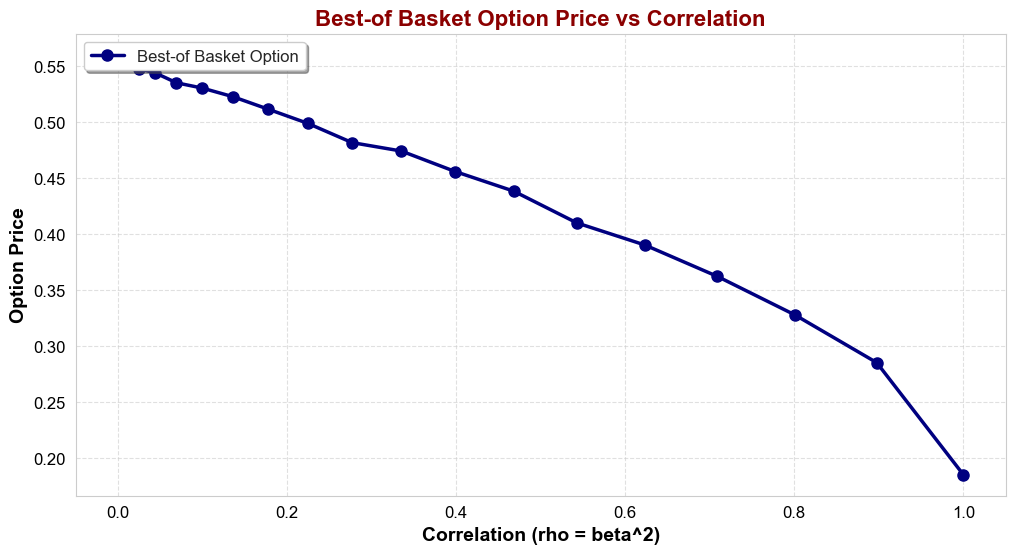

In [39]:
def plot_best_of_vs_correlation(S0, T, r, sigma, N, P, beta_range):
    """
    Plots the best-of basket option price as a function of correlation (rho = beta^2).
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    beta_values = np.linspace(beta_range[0], beta_range[1], 20)
    rho_values = beta_values**2
    prices = [basket_best(S0, T, r, sigma, beta, N, P) for beta in beta_values]
    
    plt.plot(rho_values, prices, marker='o', linestyle='-', linewidth=2.5, markersize=8, color='navy', label='Best-of Basket Option')
    
    plt.xlabel("Correlation (rho = beta^2)", fontsize=14, fontweight='bold', color='black')
    plt.ylabel("Option Price", fontsize=14, fontweight='bold', color='black')
    plt.title("Best-of Basket Option Price vs Correlation", fontsize=16, fontweight='bold', color='darkred')
    plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, fancybox=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    
    plt.show()

# Example usage
S0 = np.array([100] * 5)  # Initial stock prices for 5 assets
T = 2     # Time to maturity (2 years)
r = 0.05  # Risk-free rate (5%)
sigma = 0.25  # Volatility (25%)
N = 5  # Number of stocks in the basket
P = 10000  # Number of Monte Carlo paths
beta_range = (0, 1)  # Range of beta values

plot_best_of_vs_correlation(S0, T, r, sigma, N, P, beta_range)

## c) Worst-of Basket Option Price as a Function of Correlation

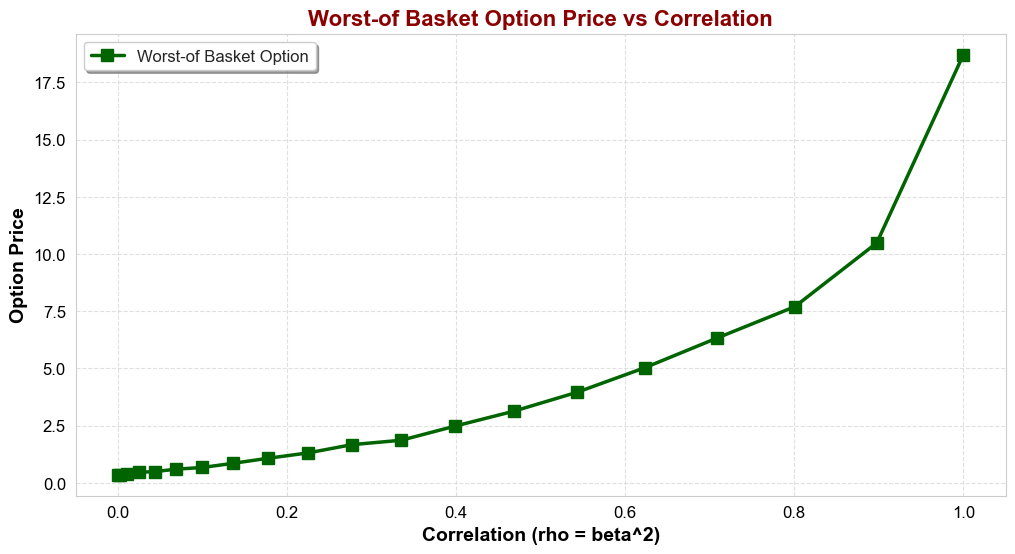

In [40]:
def basket_worst(S0, T, r, sigma, beta, N, P):
    """
    Prices a worst-of basket option using Monte Carlo simulation.
    
    Parameters:
    S0 : array - Initial stock prices of the basket
    T : float - Time to maturity
    r : float - Risk-free rate
    sigma : float - Volatility
    beta : float - Correlation parameter
    N : int - Number of assets in the basket
    P : int - Number of Monte Carlo paths
    
    Returns:
    float - Option price
    """
    dt = T  # Single time step
    Z = np.random.randn(P)  # Common market factor
    eta = np.random.randn(N, P)  # Idiosyncratic shocks

    epsilon = beta * Z + np.sqrt(1 - beta ** 2) * eta  # Correlated shocks

    ST = S0[:, np.newaxis] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * epsilon)

    # Calculate the worst performing asset in the basket
    worst_final_prices = np.min(ST, axis=0)
    payoffs = np.maximum(worst_final_prices - S0.min(), 0) * np.exp(-r * T)
    
    return np.mean(payoffs)

def plot_worst_of_vs_correlation(S0, T, r, sigma, N, P, beta_range):
    """
    Plots the worst-of basket option price as a function of correlation (rho = beta^2).
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    beta_values = np.linspace(beta_range[0], beta_range[1], 20)
    rho_values = beta_values**2
    prices = [basket_worst(S0, T, r, sigma, beta, N, P) for beta in beta_values]
    
    plt.plot(rho_values, prices, marker='s', linestyle='-', linewidth=2.5, markersize=8, color='darkgreen', label='Worst-of Basket Option')
    
    plt.xlabel("Correlation (rho = beta^2)", fontsize=14, fontweight='bold', color='black')
    plt.ylabel("Option Price", fontsize=14, fontweight='bold', color='black')
    plt.title("Worst-of Basket Option Price vs Correlation", fontsize=16, fontweight='bold', color='darkred')
    plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, fancybox=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    
    plt.show()

# Example usage
S0 = np.array([100] * 5)  # Initial stock prices for 5 assets
T = 2     # Time to maturity (2 years)
r = 0.05  # Risk-free rate (5%)
sigma = 0.25  # Volatility (25%)
N = 5  # Number of stocks in the basket
P = 10000  # Number of Monte Carlo paths
beta_range = (0, 1)  # Range of beta values

plot_worst_of_vs_correlation(S0, T, r, sigma, N, P, beta_range)


# 5. Swap Pricing

## a) Swap Pricing Function

In [41]:
def swap_value(F, T, f, c, s, swap_type):
    """
    Computes the value of an interest rate swap.
    
    Parameters:
    F : float - Face amount of the swap
    T : float - Years to maturity
    f : int - Fixed leg frequency (e.g., 1 for annual, 2 for semi-annual)
    c : float - Fixed coupon rate
    s : float - Swap rate
    swap_type : str - 'payer' or 'receiver'
    
    Returns:
    float - Present value of the swap
    """
    
    n_payments = int(T * f)  # Number of fixed payments
    dt = 1 / f  # Time step for payments
    
    discount_factors = np.exp(-s * np.arange(1, n_payments + 1) * dt)
    fixed_leg_value = F * c * dt * np.sum(discount_factors)
    floating_leg_value = F * (1 - discount_factors[-1])
    
    swap_value = floating_leg_value - fixed_leg_value if swap_type == 'payer' else fixed_leg_value - floating_leg_value
    
    return swap_value

## b) Swap Value as a Function of Swap Rate

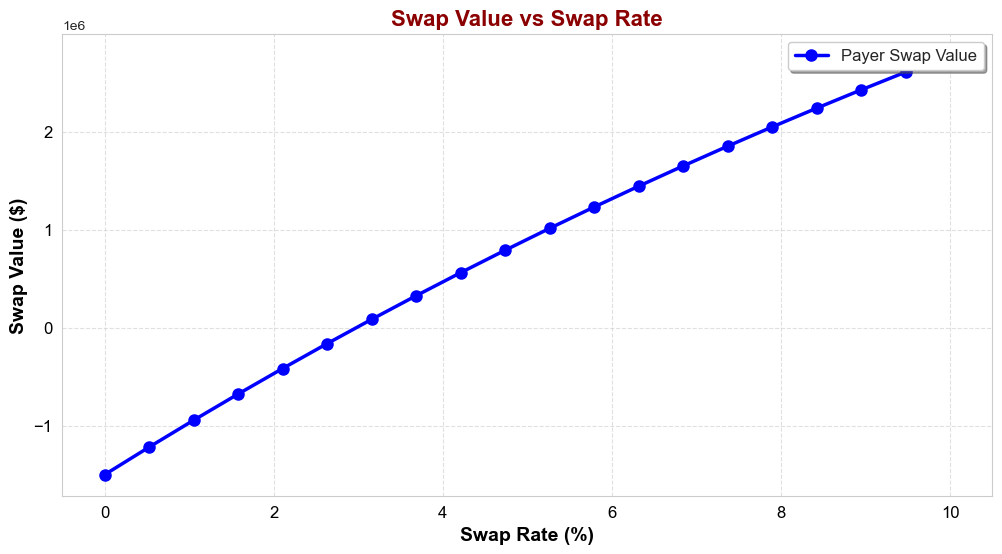

In [42]:
def plot_swap_value(F, T, f, c, swap_type):
    """
    Plots the value of a payer swap as a function of the swap rate.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    swap_rates = np.linspace(0.00, 0.10, 20)  # Swap rate from 0% to 10%
    swap_values = [swap_value(F, T, f, c, s, swap_type) for s in swap_rates]
    
    plt.plot(swap_rates * 100, swap_values, marker='o', linestyle='-', linewidth=2.5, markersize=8, color='blue', label='Payer Swap Value')
    
    plt.xlabel("Swap Rate (%)", fontsize=14, fontweight='bold', color='black')
    plt.ylabel("Swap Value ($)", fontsize=14, fontweight='bold', color='black')
    plt.title("Swap Value vs Swap Rate", fontsize=16, fontweight='bold', color='darkred')
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    
    plt.show()

# Example usage for (b)
F = 10000000  # 10 million notional
T = 5  # 5 years maturity
f = 2  # Semi-annual payments
c = 0.03  # Fixed coupon rate (3%)
swap_type = 'payer'

plot_swap_value(F, T, f, c, swap_type)

## c) Interest Rate Sensitivity of a Swap

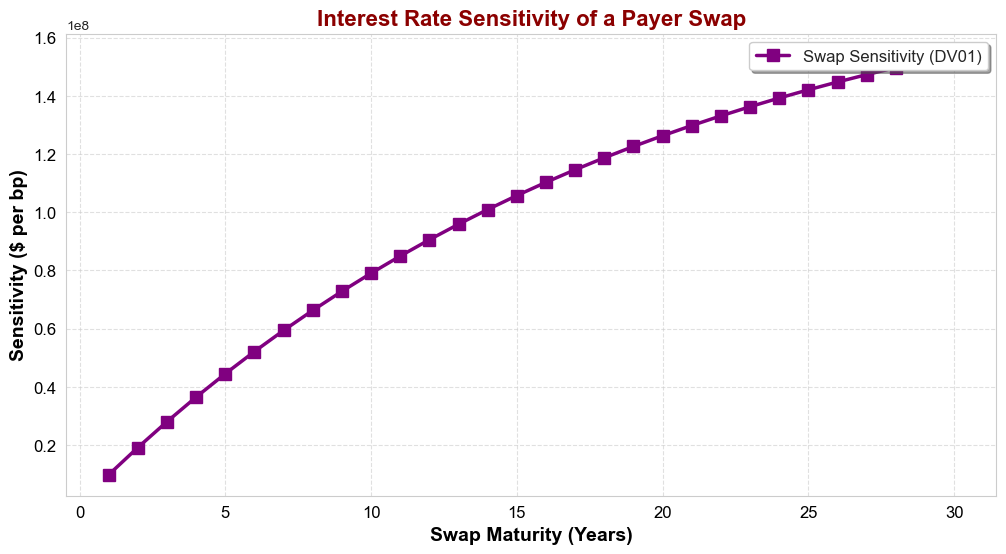

In [43]:
def interest_rate_sensitivity(F, f, c, s, T_range, swap_type):
    """
    Computes and plots the interest rate sensitivity of a payer swap by bumping the swap rate by 1bp.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    sensitivities = []
    for T in T_range:
        base_value = swap_value(F, T, f, c, s, swap_type)
        bumped_value = swap_value(F, T, f, c, s + 0.0001, swap_type)
        sensitivity = (bumped_value - base_value) / 0.0001  # DV01-like measure
        sensitivities.append(sensitivity)
    
    plt.plot(T_range, sensitivities, marker='s', linestyle='-', linewidth=2.5, markersize=8, color='purple', label='Swap Sensitivity (DV01)')
    
    plt.xlabel("Swap Maturity (Years)", fontsize=14, fontweight='bold', color='black')
    plt.ylabel("Sensitivity ($ per bp)", fontsize=14, fontweight='bold', color='black')
    plt.title("Interest Rate Sensitivity of a Payer Swap", fontsize=16, fontweight='bold', color='darkred')
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    
    plt.show()

# Example usage for (c)
F = 10000000  # 10 million notional
f = 2  # Semi-annual payments
c = 0.03  # Fixed coupon rate (3%)
s = 0.04  # Swap rate (4%)
T_range = np.arange(1, 31, 1)  # T from 1 to 30 years
swap_type = 'payer'

interest_rate_sensitivity(F, f, c, s, T_range, swap_type)

## a) CDS Pricing Function

In [44]:
def cds_value(F, T, f, c, s, r, R, swap_type):
    """
    Computes the value of a Credit Default Swap (CDS).
    
    Parameters:
    F : float - Face amount of the CDS
    T : float - Years to maturity
    f : int - Payment frequency (e.g., 1 for annual, 4 for quarterly)
    c : float - CDS coupon rate
    s : float - CDS spread (hazard rate)
    r : float - Risk-free discount rate
    R : float - Recovery rate of the underlying entity
    swap_type : str - 'buyer' or 'seller' of protection
    
    Returns:
    float - Present value of the CDS
    """
    
    n_payments = int(T * f)  # Number of premium payments
    dt = 1 / f  # Time step for payments
    
    # Discounting using risk-free rate 'r'
    discount_factors = np.exp(-r * np.arange(1, n_payments + 1) * dt)
    survival_probabilities = np.exp(-s * np.arange(1, n_payments + 1) * dt)
    
    premium_leg_value = F * c * dt * np.sum(survival_probabilities[:-1] * discount_factors[:-1])
    default_leg_value = F * (1 - R) * np.sum((survival_probabilities[:-1] - survival_probabilities[1:]) * discount_factors[:-1])
    
    cds_value = default_leg_value - premium_leg_value if swap_type == 'buyer' else premium_leg_value - default_leg_value
    
    return cds_value


## b) Plot CDS Value as a Function of CDS Spread

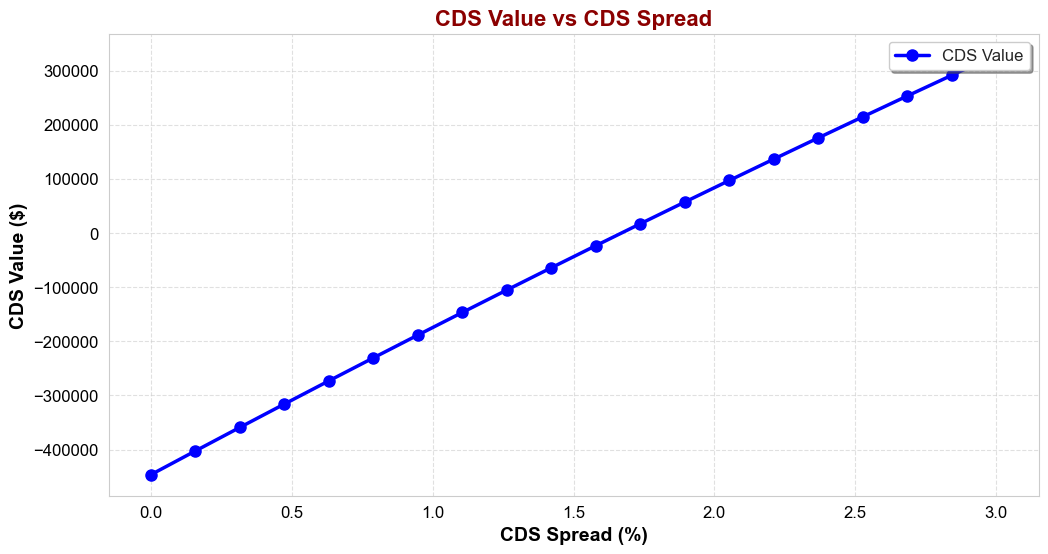

In [45]:
def plot_cds_value(F, T, f, c, r, R, swap_type):
    """
    Plots the value of a CDS long protection position as a function of the CDS spread.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    spread_rates = np.linspace(0.00, 0.03, 20)  # CDS spread from 0% to 3%
    
    # Ensure correct parameters are passed
    cds_values = [cds_value(F, T, f, c, s, r, R, swap_type) for s in spread_rates]
    
    plt.plot(spread_rates * 100, cds_values, marker='o', linestyle='-', linewidth=2.5, markersize=8, color='blue', label='CDS Value')
    
    plt.xlabel("CDS Spread (%)", fontsize=14, fontweight='bold', color='black')
    plt.ylabel("CDS Value ($)", fontsize=14, fontweight='bold', color='black')
    plt.title("CDS Value vs CDS Spread", fontsize=16, fontweight='bold', color='darkred')
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    
    plt.show()

# Example usage for (b)
F = 10000000  # 10 million notional
T = 5  # 5 years maturity
f = 4  # Quarterly payments
c = 0.01  # CDS coupon rate (1%)
r = 0.025  # Risk-free rate (2.5%)
R = 0.4  # Recovery rate 40%
swap_type = 'buyer'

plot_cds_value(F, T, f, c, r, R, swap_type)


## c) Plot Interest Rate Sensitivity of the CDS

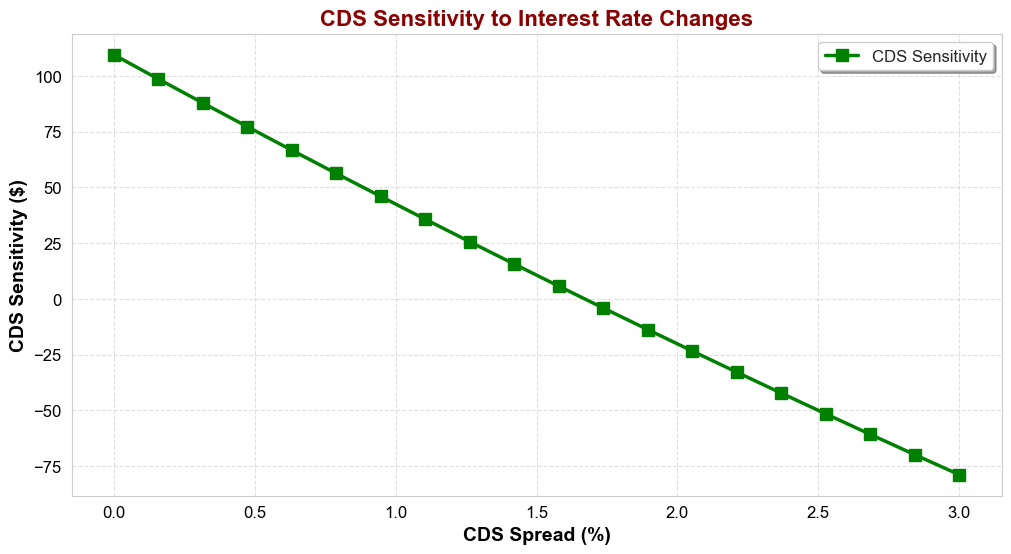

In [46]:
def cds_value(F, T, f, c, s, R, r, swap_type):
    """
    Computes the value of a Credit Default Swap (CDS).
    
    Parameters:
    F : float - Face amount of the CDS
    T : float - Years to maturity
    f : int - Payment frequency (e.g., 1 for annual, 4 for quarterly)
    c : float - CDS coupon rate
    s : float - CDS spread (hazard rate)
    R : float - Recovery rate of the underlying entity
    r : float - Risk-free rate
    swap_type : str - 'buyer' or 'seller' of protection
    
    Returns:
    float - Present value of the CDS
    """
    
    n_payments = int(T * f)  # Number of premium payments
    dt = 1 / f  # Time step for payments
    
    discount_factors = np.exp(-r * np.arange(1, n_payments + 1) * dt)  # Discounted with r
    survival_probabilities = np.exp(-s * np.arange(1, n_payments + 1) * dt)
    
    premium_leg_value = F * c * dt * np.sum(survival_probabilities[:-1] * discount_factors[:-1])
    default_leg_value = F * (1 - R) * np.sum((survival_probabilities[:-1] - survival_probabilities[1:]) * discount_factors[:-1])
    
    cds_value = default_leg_value - premium_leg_value if swap_type == 'buyer' else premium_leg_value - default_leg_value
    
    return cds_value


def plot_cds_sensitivity(F, T, f, c, R, swap_type):
    """
    Plots the interest rate sensitivity of the CDS trade as a function of CDS spread.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    spread_rates = np.linspace(0.00, 0.03, 20)  # CDS spread from 0% to 3%
    r_base = 0.025  # Base risk-free rate
    r_bumped = r_base + 0.0001  # Bumped by 1bp (0.01%)
    
    # Ensure r is passed in
    cds_values_base = [cds_value(F, T, f, c, s, R, r_base, swap_type) for s in spread_rates]
    cds_values_bumped = [cds_value(F, T, f, c, s, R, r_bumped, swap_type) for s in spread_rates]
    sensitivity = np.array(cds_values_bumped) - np.array(cds_values_base)
    
    plt.plot(spread_rates * 100, sensitivity, marker='s', linestyle='-', linewidth=2.5, markersize=8, color='green', label='CDS Sensitivity')
    
    plt.xlabel("CDS Spread (%)", fontsize=14, fontweight='bold', color='black')
    plt.ylabel("CDS Sensitivity ($)", fontsize=14, fontweight='bold', color='black')
    plt.title("CDS Sensitivity to Interest Rate Changes", fontsize=16, fontweight='bold', color='darkred')
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    
    plt.show()

# Example usage for (c)
plot_cds_sensitivity(F, T, f, c, R, swap_type)



## d) Plot Par CDS Spread Sensitivity

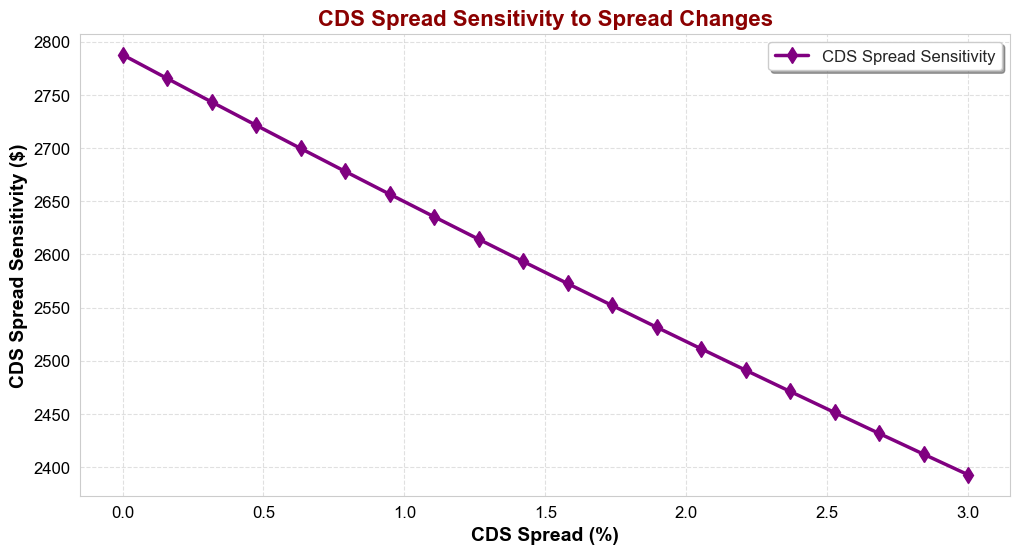

In [47]:
def plot_cds_spread_sensitivity(F, T, f, c, R, r, swap_type):
    """
    Plots the par CDS spread sensitivity by bumping the CDS spread by 1bp.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    spread_rates = np.linspace(0.00, 0.03, 20)  # CDS spread from 0% to 3%
    bump = 0.0001  # 1bp bump
    
    cds_values_base = [cds_value(F, T, f, c, s, R, r, swap_type) for s in spread_rates]
    cds_values_bumped = [cds_value(F, T, f, c, s + bump, R, r, swap_type) for s in spread_rates]
    sensitivity = np.array(cds_values_bumped) - np.array(cds_values_base)
    
    plt.plot(spread_rates * 100, sensitivity, marker='d', linestyle='-', linewidth=2.5, markersize=8, color='purple', label='CDS Spread Sensitivity')
    
    plt.xlabel("CDS Spread (%)", fontsize=14, fontweight='bold', color='black')
    plt.ylabel("CDS Spread Sensitivity ($)", fontsize=14, fontweight='bold', color='black')
    plt.title("CDS Spread Sensitivity to Spread Changes", fontsize=16, fontweight='bold', color='darkred')
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    
    plt.show()

# Example usage for (d)
r = 0.025  # Risk-free rate 2.5%
plot_cds_spread_sensitivity(F, T, f, c, R, r, swap_type)


## e) Plot Recovery Rate Sensitivity

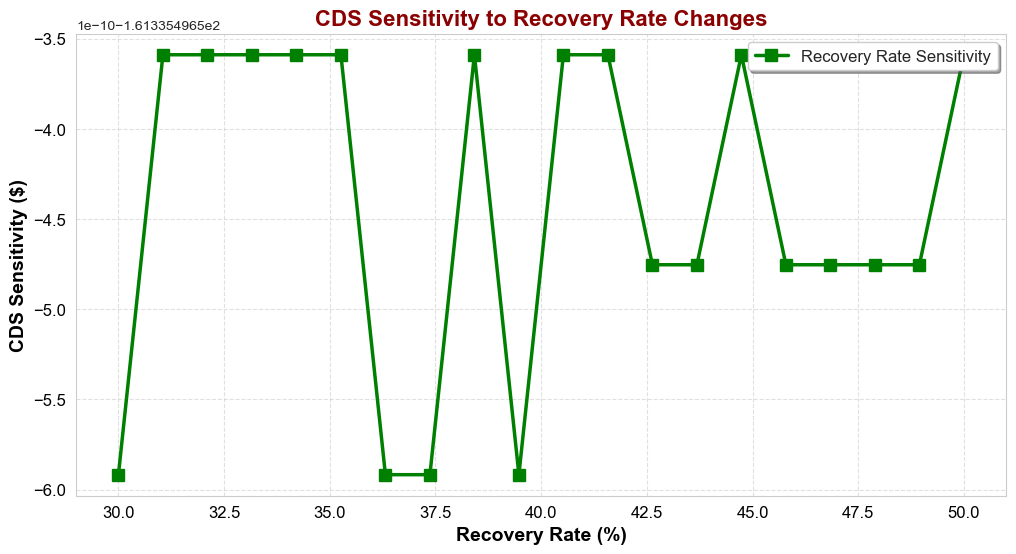

In [48]:
def plot_cds_recovery_sensitivity(F, T, f, c, s, r, swap_type):
    """
    Plots the recovery rate sensitivity by bumping the recovery rate by 1bp.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    recovery_rates = np.linspace(0.3, 0.5, 20)  # Recovery rate from 30% to 50%
    bump = 0.0001  # 1bp bump
    
    cds_values_base = [cds_value(F, T, f, c, s, R, r, swap_type) for R in recovery_rates]
    cds_values_bumped = [cds_value(F, T, f, c, s, R + bump, r, swap_type) for R in recovery_rates]
    sensitivity = np.array(cds_values_bumped) - np.array(cds_values_base)
    
    plt.plot(recovery_rates * 100, sensitivity, marker='s', linestyle='-', linewidth=2.5, markersize=8, color='green', label='Recovery Rate Sensitivity')
    
    plt.xlabel("Recovery Rate (%)", fontsize=14, fontweight='bold', color='black')
    plt.ylabel("CDS Sensitivity ($)", fontsize=14, fontweight='bold', color='black')
    plt.title("CDS Sensitivity to Recovery Rate Changes", fontsize=16, fontweight='bold', color='darkred')
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    
    plt.show()

# Example usage for (e)
plot_cds_recovery_sensitivity(F, T, f, c, s, r, swap_type)
